## Lime Analysis of Densenet - 201 on ASD Dataset

In [1]:
!pip install lime

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import glob
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [3]:
DATA_PATH = "/kaggle/input/autism-image-data/AutismDataset"
MODEL_PATH = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_densenet201_autism.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_PATH = "/kaggle/working"

In [4]:
def load_test_dataset():
    """Load and summarize test dataset structure and return metadata.
    Preview samples randomly drawn (up to 5 per class)."""
    test_path = os.path.join(DATA_PATH, "test")

    if not os.path.exists(test_path):
        print(f"Test directory not found: {test_path}")
        return None

    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    all_images = []

    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(test_path, ext)))
        all_images.extend(glob.glob(os.path.join(test_path, ext.upper())))

    autistic_images = [img for img in all_images if 'Autistic.' in os.path.basename(img)]
    non_autistic_images = [img for img in all_images if 'Non_Autistic.' in os.path.basename(img)]

    print("Test Dataset Summary:")
    print(f"  Total images: {len(all_images)}")
    print(f"  Autistic images: {len(autistic_images)}")
    print(f"  Non-Autistic images: {len(non_autistic_images)}")

    import random
    sample_autistic = random.sample(autistic_images, min(5, len(autistic_images))) if autistic_images else []
    sample_non_autistic = random.sample(non_autistic_images, min(5, len(non_autistic_images))) if non_autistic_images else []

    return {
        'all_images': all_images,
        'autistic_images': autistic_images,
        'non_autistic_images': non_autistic_images,
        'sample_autistic': sample_autistic,
        'sample_non_autistic': sample_non_autistic
    }

In [5]:
# Initial dataset loading (selection occurs AFTER predictions)
import random

test_dataset = load_test_dataset()

selected_image_paths = []  # will be populated after predictions

if not test_dataset:
    print("No dataset information available. Please check the data path.")
else:
    print("Dataset loaded. Run model + prediction cells to generate selection.")

Test Dataset Summary:
  Total images: 300
  Autistic images: 300
  Non-Autistic images: 150
Dataset loaded. Run model + prediction cells to generate selection.


In [6]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])   

    return transform

def get_input_tensors(img):
    transform = get_input_transform()
    # unsqueeze converts single image to batch of 1
    return transform(img).unsqueeze(0)

In [7]:
class DenseNet201(nn.Module):
    def __init__(self, num_classes=2, pretrained=False, dropout_rate=0.5):
        super(DenseNet201, self).__init__()
        model = models.densenet201(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/4),
            nn.Linear(256, num_classes)
        )
        self.features = model.features
        self.classifier = model.classifier
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [8]:
model = DenseNet201()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet201(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [9]:
def select_samples_by_prediction(results, total=6, ratio_correct=0.5, shuffle=True, seed=None):
    """Select image records based on model prediction correctness balance."""
    if not results:
        return [], []
    import random
    rnd = random.Random(seed)
    correct = [r for r in results if r['correct']]
    incorrect = [r for r in results if not r['correct']]
    if shuffle:
        rnd.shuffle(correct)
        rnd.shuffle(incorrect)
    need_correct = int(round(total * ratio_correct))
    need_incorrect = total - need_correct
    sel_correct = correct[:need_correct]
    sel_incorrect = incorrect[:need_incorrect]
    if len(sel_correct) < need_correct:
        deficit = need_correct - len(sel_correct)
        extras = incorrect[need_incorrect:need_incorrect+deficit]
        sel_incorrect.extend(extras)
    if len(sel_incorrect) < need_incorrect:
        deficit = need_incorrect - len(sel_incorrect)
        extras = correct[need_correct:need_correct+deficit]
        sel_correct.extend(extras)
    selected = sel_correct + sel_incorrect
    if shuffle:
        rnd.shuffle(selected)
    return selected, [r['path'] for r in selected]

In [10]:
# Helper: compute predictions over all test images
from typing import List, Dict

def compute_predictions(test_dataset, batch_size=16):
    if not test_dataset:
        print("No dataset info provided.")
        return []
    image_paths = test_dataset['all_images']
    results = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    softmax = torch.nn.Softmax(dim=1)
    model.eval()

    def true_label_from_name(p):
        name = os.path.basename(p)
        if 'Non_Autistic.' in name:
            return 0
        if 'Autistic.' in name:
            return 1
        return None

    batch = []
    batch_meta = []

    def flush_batch():
        if not batch:
            return
        with torch.no_grad():
            tensor_batch = torch.stack(batch).to(DEVICE)
            logits = model(tensor_batch)
            probs = softmax(logits)
            confs, preds = torch.max(probs, 1)
            for meta, pred, conf, prob_vec in zip(batch_meta, preds.cpu(), confs.cpu(), probs.cpu()):
                results.append({
                    'path': meta['path'],
                    'true': meta['true'],
                    'pred': int(pred.item()),
                    'conf': float(conf.item()),
                    'prob_autistic': float(prob_vec[1].item()),
                    'correct': (meta['true'] is not None and int(pred.item()) == meta['true'])
                })
        batch.clear()
        batch_meta.clear()

    for p in image_paths:
        tlabel = true_label_from_name(p)
        try:
            img = Image.open(p).convert('RGB')
            batch.append(transform(img))
            batch_meta.append({'path': p, 'true': tlabel})
            if len(batch) == batch_size:
                flush_batch()
        except Exception as e:
            print(f"Skipping {p}: {e}")
    flush_batch()

    return results

In [11]:
# If your dataset labels were 0 = non-autistic, 1 = autistic
idx2label = ["non-autistic", "autistic"]
cls2idx = {"non-autistic": 0, "autistic": 1}
cls2label = {"non-autistic": "non-autistic", "autistic": "autistic"}

In [12]:
model.eval()  # put model in eval mode

for img in selected_image_paths:
    img_t = get_input_tensors(Image.open(img)).to(DEVICE)
    with torch.no_grad():
        output = model(img_t)
    _, predicted = torch.max(output, 1)
    predicted_label = idx2label[predicted.item()]
    print(f"Image: {os.path.basename(img)} | Predicted: {predicted_label}")

In [13]:
# Compute predictions and select sample set
prediction_records = compute_predictions(test_dataset)
print(f"Computed predictions for {len(prediction_records)} images")

sample_records, selected_image_paths = select_samples_by_prediction(
    prediction_records,
    total=6,
    ratio_correct=0.8,
    shuffle=True,
    seed=None,
)

print("Selected sample set (filename | prob_autistic | correct):")
for r in sample_records:
    status = 'OK' if r['correct'] else 'WRONG'
    print(f"  {os.path.basename(r['path'])} | {r['prob_autistic']:.3f} | {status}")

Computed predictions for 300 images
Selected sample set (filename | prob_autistic | correct):
  Autistic.25.jpg | 0.637 | OK
  Autistic.30.jpg | 0.989 | OK
  Non_Autistic.76.jpg | 0.286 | OK
  Non_Autistic.112.jpg | 0.060 | OK
  Autistic.47.jpg | 0.004 | WRONG
  Non_Autistic.55.jpg | 0.006 | OK


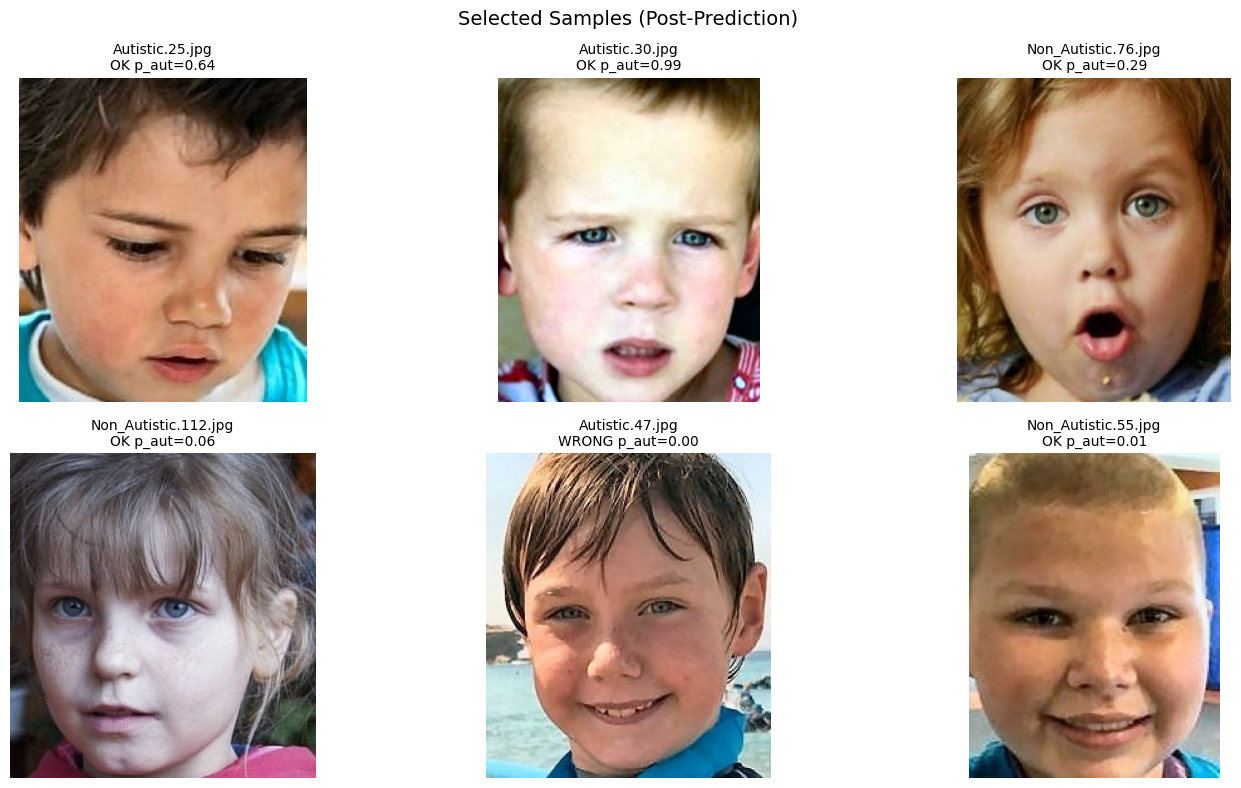

In [14]:
# Visualize selected samples with prediction status
if selected_image_paths:
    cols = min(3, len(selected_image_paths))
    rows = (len(selected_image_paths) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    if rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    meta_by_path = {r['path']: r for r in sample_records}
    for i, p in enumerate(selected_image_paths):
        img = Image.open(p)
        axes[i].imshow(img)
        rec = meta_by_path.get(p, {})
        status = 'OK' if rec.get('correct') else 'WRONG'
        prob = rec.get('prob_autistic')
        prob_txt = f"p_aut={prob:.2f}" if prob is not None else ''
        axes[i].set_title(f"{os.path.basename(p)}\n{status} {prob_txt}", fontsize=10)
        axes[i].axis('off')
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.suptitle('Selected Samples (Post-Prediction)', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No selected images to visualize yet.")

In [15]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [16]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(pill_transf(Image.fromarray(i))) for i in images), dim=0)
    batch = batch.to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

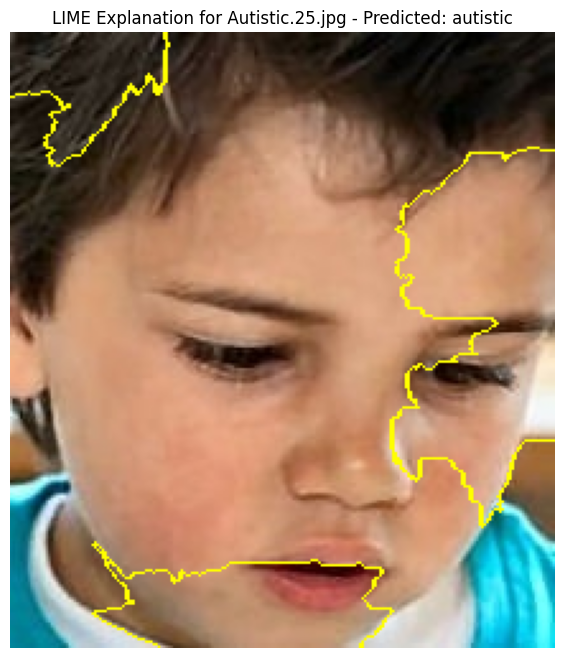

  0%|          | 0/1000 [00:00<?, ?it/s]

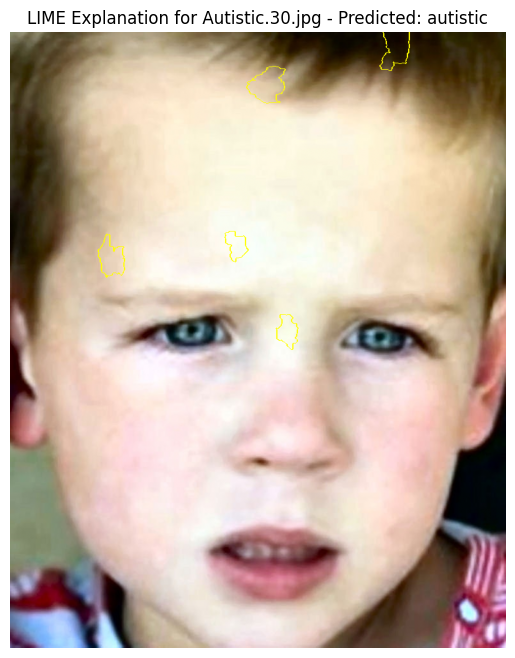

  0%|          | 0/1000 [00:00<?, ?it/s]

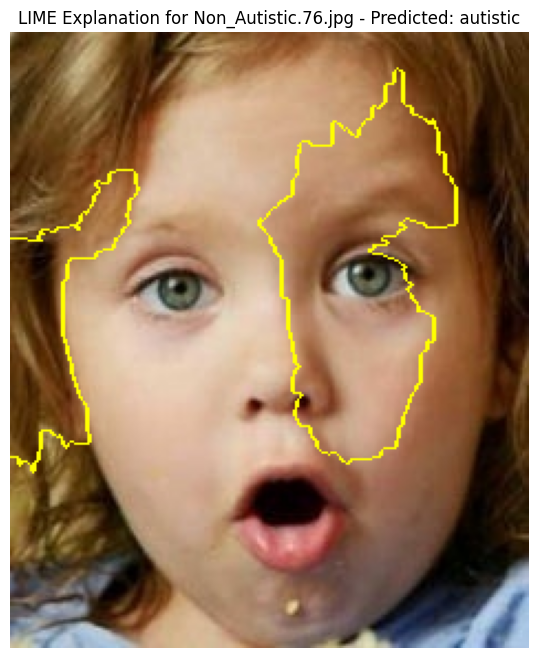

  0%|          | 0/1000 [00:00<?, ?it/s]

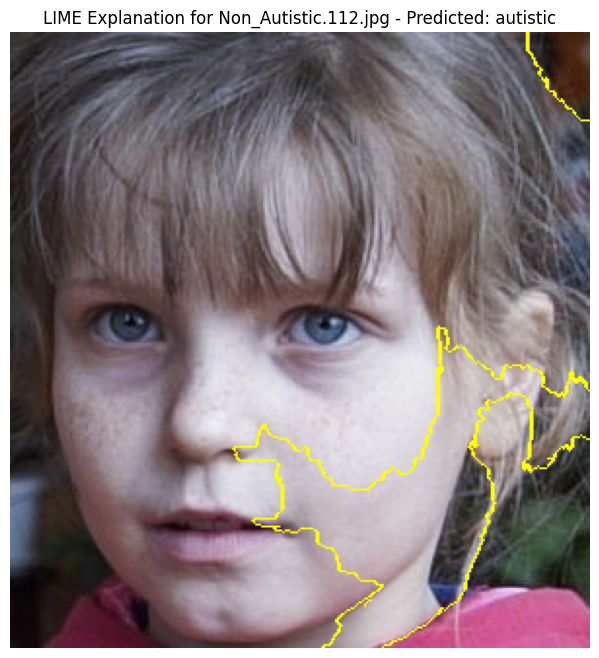

  0%|          | 0/1000 [00:00<?, ?it/s]

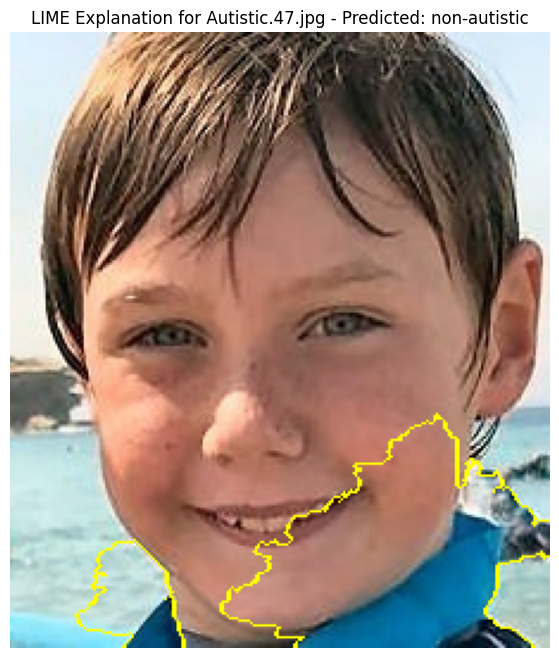

  0%|          | 0/1000 [00:00<?, ?it/s]

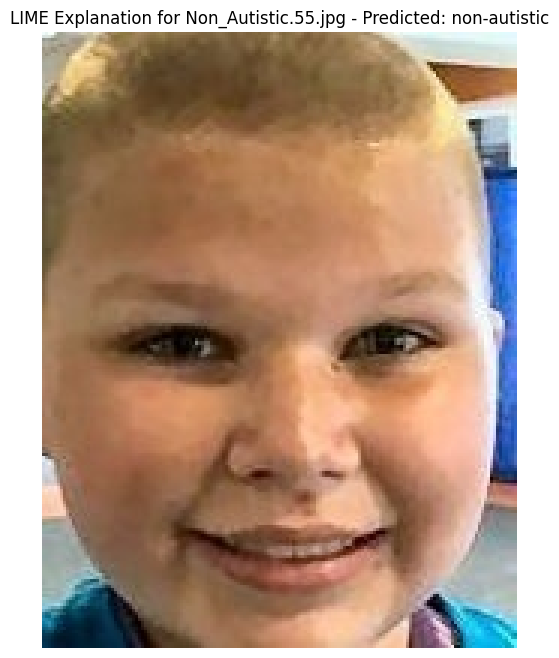

In [17]:
image_dirs = os.path.join(OUTPUT_PATH, "dnet_201_lime")
os.makedirs(image_dirs, exist_ok=True)

boundary_dir = os.path.join(image_dirs, "boundary")
os.makedirs(boundary_dir, exist_ok=True)

explainer = lime_image.LimeImageExplainer()

for i, img_path in enumerate(selected_image_paths):
    img = Image.open(img_path).convert("RGB")
    image_np = np.array(img)

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False,
    )

    img_bound = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_bound)
    plt.title(
        f"LIME Explanation for {os.path.basename(img_path)} - "
        f"Predicted: {idx2label[explanation.top_labels[0]]}"
    )
    plt.axis("off")
    plt.savefig(os.path.join(boundary_dir, f"{i}.png"))
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

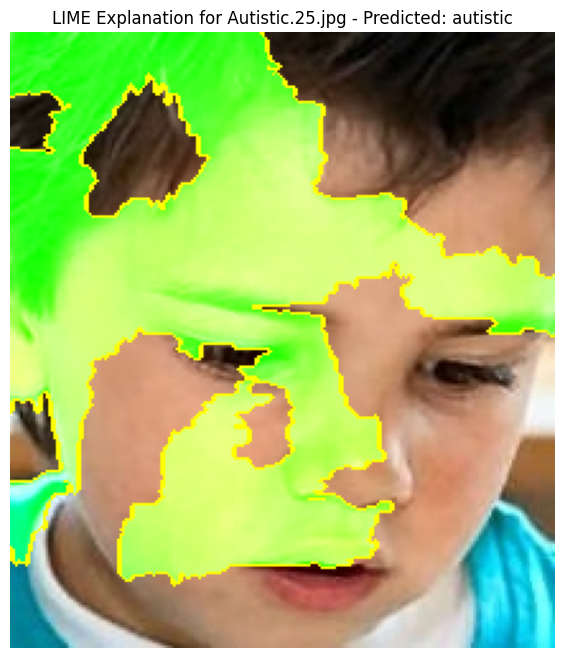

  0%|          | 0/1000 [00:00<?, ?it/s]

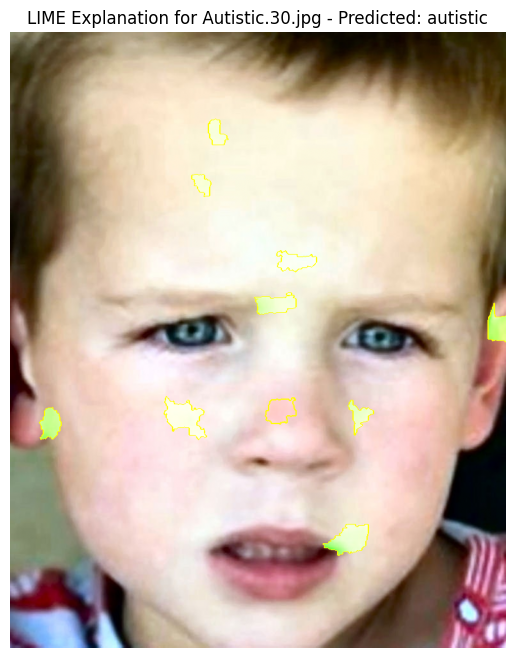

  0%|          | 0/1000 [00:00<?, ?it/s]

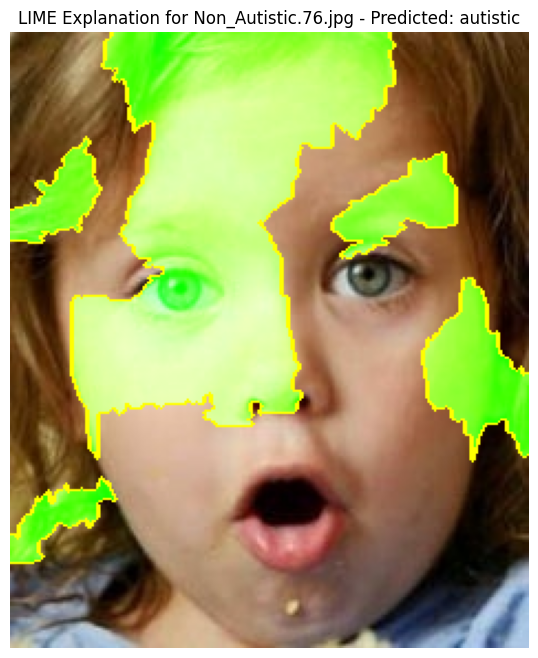

  0%|          | 0/1000 [00:00<?, ?it/s]

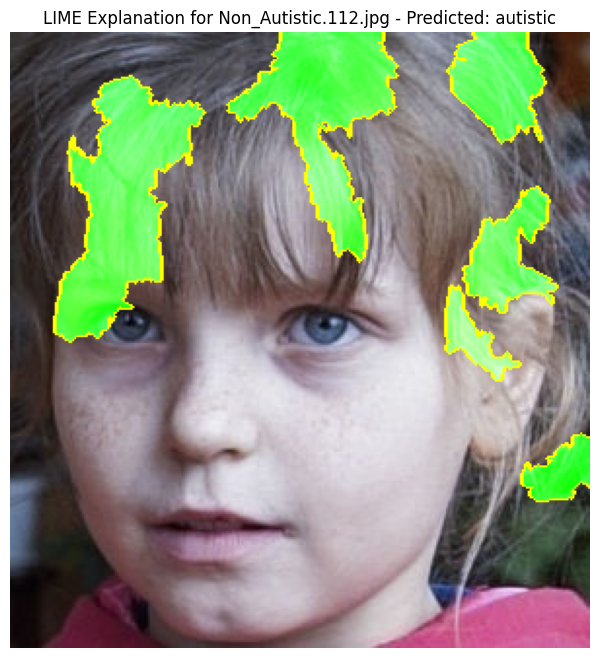

  0%|          | 0/1000 [00:00<?, ?it/s]

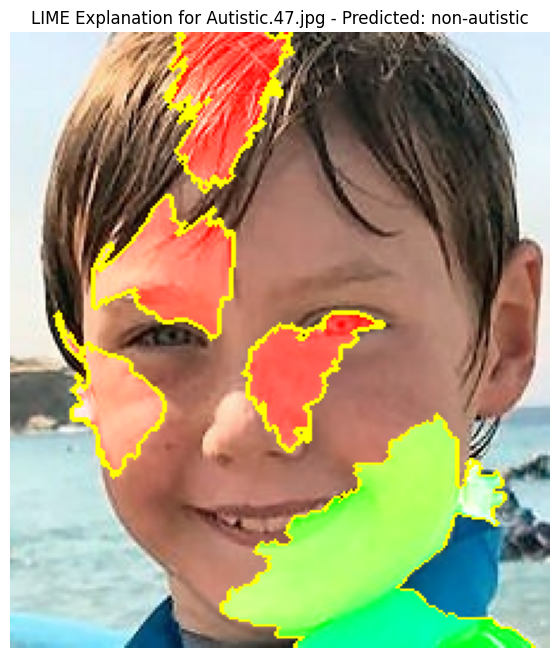

  0%|          | 0/1000 [00:00<?, ?it/s]

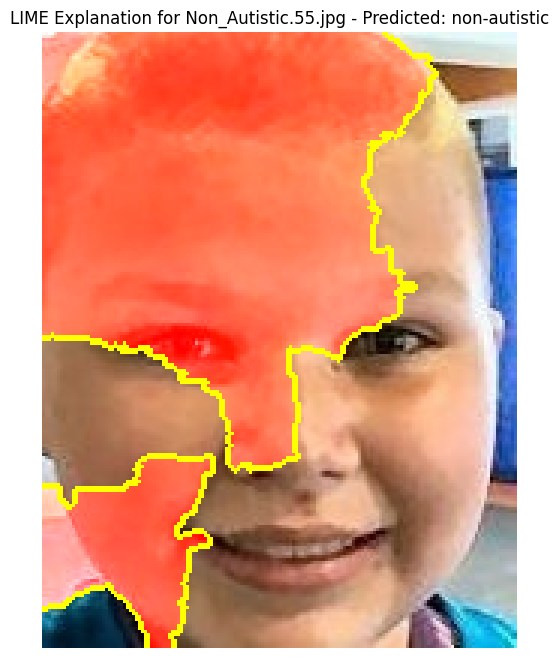

In [18]:
region_dir = os.path.join(image_dirs, "region")
os.makedirs(region_dir, exist_ok=True)

explainer = lime_image.LimeImageExplainer()

for i, img_path in enumerate(selected_image_paths):
    img = Image.open(img_path).convert("RGB")
    image_np = np.array(img)

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False,
    )

    img_bound = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_bound)
    plt.title(
        f"LIME Explanation for {os.path.basename(img_path)} - "
        f"Predicted: {idx2label[explanation.top_labels[0]]}"
    )
    plt.axis("off")
    plt.savefig(os.path.join(region_dir, f"{i}.png"))
    plt.show()

## SHAP Analysis of Densenet - 201 on ASD Dataset

In [19]:
!pip install shap

In [20]:
import shap

In [21]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.is_sparse:
        x = x.to_dense()
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.is_sparse:
        x = x.to_dense()
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Lambda(lambda x: x * (1 / 255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = transforms.Compose(transform)
inv_transform = transforms.Compose(inv_transform)

In [22]:
# Resize + normalize in predict()
def predict(img: np.ndarray) -> torch.Tensor:
    if img.ndim == 4:  # batch
        img = torch.tensor(img).permute(0, 3, 1, 2)  # NHWC -> NCHW
    elif img.ndim == 3:  # single
        img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)  # HWC -> NCHW
    else:
        raise ValueError(f"Unexpected input shape: {img.shape}")

    img = img.float() / 255.0
    img = transforms.Resize((224, 224))(img)
    img = transforms.Normalize(mean=mean, std=std)(img)
    img = img.to(DEVICE)

    with torch.no_grad():
        output = model(img)

    return output

In [23]:
topk = 4
batch_size = 50
n_evals = 10000

model.eval()

# Load selected images as arrays for SHAP
images = np.stack(
    [np.array(Image.open(p).convert("RGB").resize((224, 224))) for p in selected_image_paths]
)

masker_blur = shap.maskers.Image("blur(128,128)", (224, 224, 3))

explainer = shap.Explainer(predict, masker_blur, output_names=idx2label)

shap_values = explainer(
    images,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [01:40<01:11, 23.92s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [02:28<01:07, 33.72s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [03:15<00:38, 38.98s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [04:04<00:00, 42.14s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [04:51, 48.66s/it]                       


In [24]:
(shap_values.data.shape, shap_values.values.shape)

((6, 224, 224, 3), (6, 224, 224, 3, 2))

In [25]:
# Invert transform for visualization
shap_values.data = inv_transform(torch.tensor(shap_values.data).float() / 255.0).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

In [26]:
(shap_values.data.shape, shap_values.values[0].shape)

((6, 224, 224, 3), (6, 224, 224, 3))

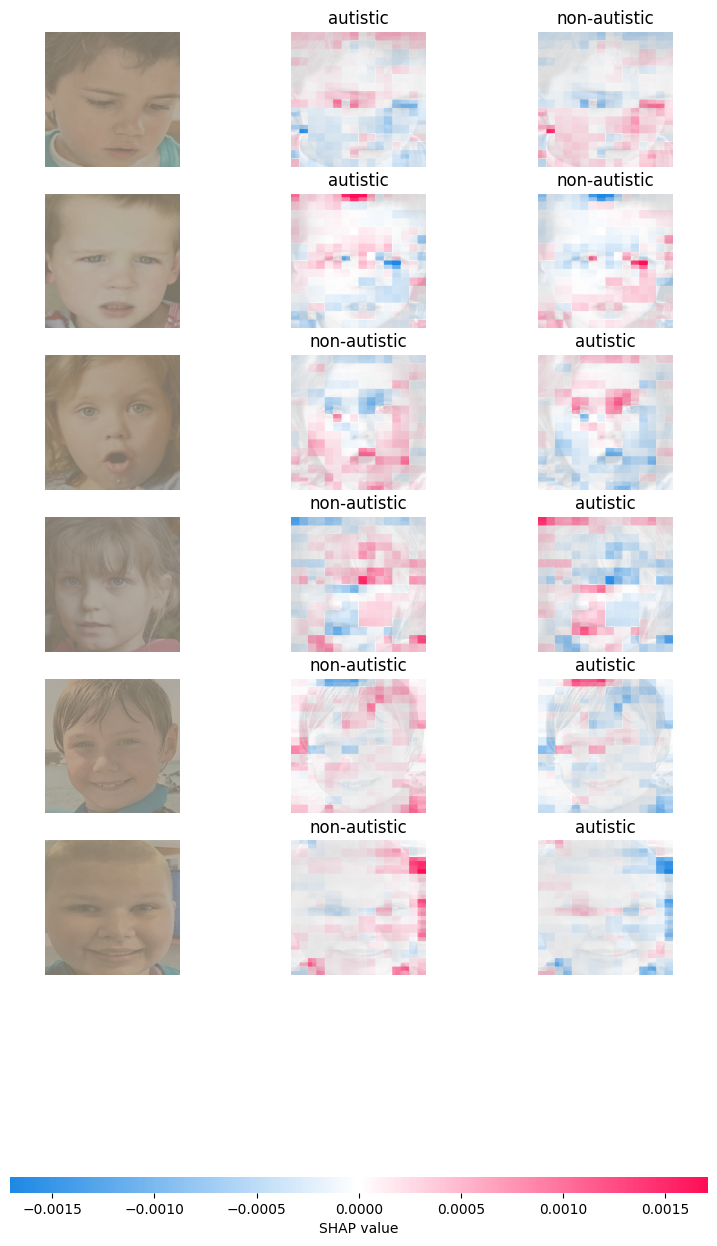

In [27]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
)